In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import json

from IPython.display import display

In [2]:
sns.set_context("poster")
sns.set_style("ticks")

In [3]:
test_stat_files = glob("../data/models_old/*/test_stats.json")

In [4]:
test_stat_files

['../data/models_old\\all_multitask_shared\\test_stats.json',
 '../data/models_old\\all_multitask_shared_l2_0_lr_0.001\\test_stats.json',
 '../data/models_old\\all_multitask_shared_l2_0_lr_0.001_no_neel_no_dimsum\\test_stats.json',
 '../data/models_old\\all_multitask_shared_no_neel_no_dimsum\\test_stats.json',
 '../data/models_old\\all_multitask_shared_sa_l2_0_lr_0.001\\test_stats.json',
 '../data/models_old\\all_multitask_shared_ssa\\test_stats.json',
 '../data/models_old\\all_multitask_shared_ssa_l2_0_lr_0.001\\test_stats.json',
 '../data/models_old\\all_multitask_stacked\\test_stats.json',
 '../data/models_old\\all_multitask_stacked_l2_0_lr_0.001\\test_stats.json',
 '../data/models_old\\all_multitask_stacked_l2_0_lr_0.001_no_neel_no_dimsum\\test_stats.json',
 '../data/models_old\\all_multitask_stacked_no_neel_no_dimsum\\test_stats.json',
 '../data/models_old\\all_ner\\test_stats.json',
 '../data/models_old\\all_ner_bilstm\\test_stats.json',
 '../data/models_old\\all_ner_bilstm_l2_0_

In [5]:
def parse_stats(stat, model):
    stats = []
    for task, task_stat in stat.items():
        task_suffix = task.rsplit("_")[-1]
        for file, file_stat in task_stat.items():
            if task_suffix in set(["ner", "chunk", "ccg"]):
                file_stat = {
                    k.rsplit("_")[-1]:v for k,v in file_stat.items()
                    if k.endswith("f1-measure-overall")
                }
            else:
                file_stat = {
                    k.rsplit("_")[-1]:v for k,v in file_stat.items()
                    if k.endswith("accuracy")
                }
            file_stat["file"] = "_".join(file.split("/")[-3:-1])
            file_stat["task"] = task
            file_stat["task_type"] = task_suffix
            file_stat["model"] = model
            stats.append(file_stat)
    return stats

In [6]:
def parse_model_name(file):
    model = file.split("\\")[-2]
    model = model.replace("l2_0_lr_0.001", "*")
    model = model.replace("l2_0_lr_1e-3", "*")
    model = model.replace("no_neel_no_dimsum", "#") 
    model = model.replace("no_neel", "#") 
    model = model.replace("no_dimsum", "#")
    model = model.replace("self_attention", "sa")
    model = model.split("_")
    if model[0] != "all":
        model[0] = "single"
    if model[:2] == ["all", "multitask"]:
        model = model[1:]
    if model[:2] == ["all", "ner"] or model[:2] == ["all", "pos"]:
        model = ["multidata"]+model[2:]
    model = " ".join(model)
    return model

In [7]:
stats = []
for file in test_stat_files:
    with open(file) as fp:
        stat = json.load(fp)
        model = parse_model_name(file)
        stats.extend(parse_stats(stat, model))
df = pd.DataFrame(stats)
df.head()

,accuracy,f1-measure-overall,file,model,task,task_type
0,NaN,0.757597,NER_MSM2013,multitask shared,multimodal_ner,ner
1,NaN,0.680440,NER_MultiModal,multitask shared,multimodal_ner,ner
2,NaN,0.683815,NER_BROAD,multitask shared,broad_ner,ner
3,NaN,0.511842,NER_Finin,multitask shared,broad_ner,ner
4,NaN,0.726279,NER_Hege,multitask shared,broad_ner,ner


In [8]:
def get_model_type(x):
    if "single" in x: return "single"
    if "multitask" in x: return "multitask"
    return "multidataset"

def plot_measures(df, task="pos", measure="accuracy"):
    df_t = df[df.task_type == task][[measure, "file", "model"]].assign(
        file=lambda df_temp: df_temp["file"].str.split("_", 1, expand=True)[1]
    ).pivot(
        index="model",
        columns="file"
    ).fillna(0)[measure] * 100.0
    df_tt = df[df.task_type == task][[measure, "file", "model"]].assign(
        file=lambda df_temp: df_temp["file"].str.split("_", 1, expand=True)[1],
        model_type=lambda df_temp: df_temp["model"].map(get_model_type),
        **{
            measure: lambda df_temp: df_temp[measure]*100.
        }
    )
    df_t = df_t.assign(mean_value=df_t.mean(axis=1)).sort_values("mean_value", ascending=False).drop("mean_value", axis=1)
    sort_order = df_t.index.values
    nmodels, ncols = df_t.shape
    display(df_t)
    nfig_cols = 3
    nrows = np.ceil(ncols/nfig_cols).astype(int)
    
    """
    df_t.plot(
        kind="barh", figsize=(20,(0.5*nmodels)*nrows), subplots=True, legend=False,
        sharex=False, color="0.5", layout=(nrows,nfig_cols), sharey=True
    )
    """
    g = sns.FacetGrid(
        data=df_tt, 
        col="file", col_wrap=3,
        height=0.5*df_t.shape[0], aspect=1,
        sharex=False
    )
    g.map(sns.stripplot, measure, "model", orient="h", size=20, color="black", order=sort_order)
    plt.tight_layout()
    
    df_t_ranked = df_t.rank(ascending=False).astype(int)
    df_t_merged = pd.concat([df_t_ranked, df_t], 
        keys=["r", "v"],
        axis=1
    ).reorder_levels([1, 0], axis=1).sort_index(axis=1)
    with pd.option_context("precision", 2):
        display(df_t_merged) 
        print(df_t_merged.to_latex(bold_rows=True, multicolumn_format='c'))
    
    fig = plt.figure(figsize=(10, 10))
    print(df_t.columns)
    sns.heatmap(
        df_t_ranked.T, 
        cmap="viridis_r", linewidths=.5, annot=True, fmt="d",
        square=True,
        cbar_kws = dict(use_gridspec=False,location="top")
    )
    
    display(pd.concat([df_t.idxmax(), df_t.max()], axis=1, keys=["model", "score"]))
    return df_t

file,Foster,Owoputi,Ritter,Tweetbankv2,TwitIE,lowlands
model,,,,,,
multidata bilstm *,65.821894,91.708613,90.842041,93.574234,90.566702,63.281803
multitask shared * #,65.469905,91.219239,91.026429,93.479969,90.637100,63.008993
multitask stacked *,65.153115,91.317114,90.411801,93.343807,90.496304,62.503789
multitask shared ssa *,65.117916,90.380313,91.026429,92.699660,91.024287,62.140042
multitask stacked * #,64.202746,91.149329,90.719115,93.474732,90.813094,61.836920
multitask shared *,65.012320,90.631991,90.288875,93.186698,89.299542,62.185511
multidata bilstm #,65.469905,89.946868,89.858636,92.804399,89.721929,62.741235
single pos *,66.455473,90.687919,89.674247,90.573449,89.475537,62.301708
multidata sa *,66.138684,90.310403,89.674247,90.720084,89.158747,62.114782


file                   Foster        Owoputi        Ritter        Tweetbankv2  \
                            r      v       r      v      r      v           r   
model                                                                           
multidata bilstm *          7  65.82       1  91.71      3  90.84           1   
multitask shared * #        8  65.47       3  91.22      1  91.03           2   
multitask stacked *        13  65.15       2  91.32      5  90.41           4   
multitask shared ssa *     14  65.12      10  90.38      1  91.03           7   
multitask stacked * #      17  64.20       4  91.15      4  90.72           3   
multitask shared *         15  65.01       8  90.63      7  90.29           5   
multidata bilstm #          8  65.47      12  89.95     10  89.86           6   
single pos *                4  66.46       7  90.69     11  89.67          11   
multidata sa *              5  66.14      11  90.31     11  89.67           9   
multidata *                10  65.22       5  90.72      6  90.35          13   
multitask shared sa *      10  65.22       9  90.56      9  89.98          17   
single pos                 19  63.67       6  90.70      8  90.23          15   
multidata sa                6  65.96      16  87.57     14  87.89          14   
multidata                  12  65.19      14  88.37     13  88.69          18   
multidata bilstm           18  64.10      13  88.48     15  86.85           8   
multitask stacked           3  66.63      19  85.11     16  85.25          19   
multitask stacked #        15  65.01      15  87.58     17  82.48          12   
multitask shared #          2  67.05      18  86.51     18  80.15          10   
multitask shared            1  67.23      17  86.55     19  76.34          16   
multitask shared ssa       20  23.41      20  14.99     20   7.74          20   

file                          TwitIE        lowlands         
                            v      r      v        r      v  
model                                                        
multidata bilstm *      93.57      4  90.57        2  63.28  
multitask shared * #    93.48      3  90.64        5  63.01  
multitask stacked *     93.34      5  90.50        7  62.50  
multitask shared ssa *  92.70      1  91.02       12  62.14  
multitask stacked * #   93.47      2  90.81       14  61.84  
multitask shared *      93.19     11  89.30       11  62.19  
multidata bilstm #      92.80      7  89.72        6  62.74  
single pos *            90.57      9  89.48        9  62.30  
multidata sa *          90.72     12  89.16       13  62.11  
multidata *             90.16     10  89.41       18  61.17  
multitask shared sa *   89.12      6  90.29       16  61.36  
single pos              89.60      8  89.62       19  60.28  
multidata sa            90.04     14  87.29        8  62.39  
multidata               88.94     13  87.54       15  61.68  
multidata bilstm        91.13     15  87.26       17  61.19  
multitask stacked       87.76     16  84.37        4  63.10  
multitask stacked #     90.27     17  82.40       10  62.27  
multitask shared #      90.62     18  80.99        1  63.66  
multitask shared        89.51     19  74.94        3  63.24  
multitask shared ssa    10.70     20  21.26       20  15.16

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
\textbf{file} & \multicolumn{2}{c}{Foster} & \multicolumn{2}{c}{Owoputi} & \multicolumn{2}{c}{Ritter} & \multicolumn{2}{c}{Tweetbankv2} & \multicolumn{2}{c}{TwitIE} & \multicolumn{2}{c}{lowlands} \\
{} &      r &      v &       r &      v &      r &      v &           r &      v &      r &      v &        r &      v \\
\textbf{model                 } &        &        &         &        &        &        &             &        &        &        &          &        \\
\midrule
\textbf{multidata bilstm *    } &      7 &  65.82 &       1 &  91.71 &      3 &  90.84 &           1 &  93.57 &      4 &  90.57 &        2 &  63.28 \\
\textbf{multitask shared * \#  } &      8 &  65.47 &       3 &  91.22 &      1 &  91.03 &           2 &  93.48 &      3 &  90.64 &        5 &  63.01 \\
\textbf{multitask stacked *   } &     13 &  65.15 &       2 &  91.32 &      5 &  90.41 &           4 &  93.34 &      5 &  90.50 &        7 &  62.50 \\
\textbf{multitask shared 

,model,score
file,,
Foster,multitask shared,67.229849
Owoputi,multidata bilstm *,91.708613
Ritter,multitask shared * #,91.026429
Tweetbankv2,multidata bilstm *,93.574234
TwitIE,multitask shared ssa *,91.024287
lowlands,multitask shared #,63.660705


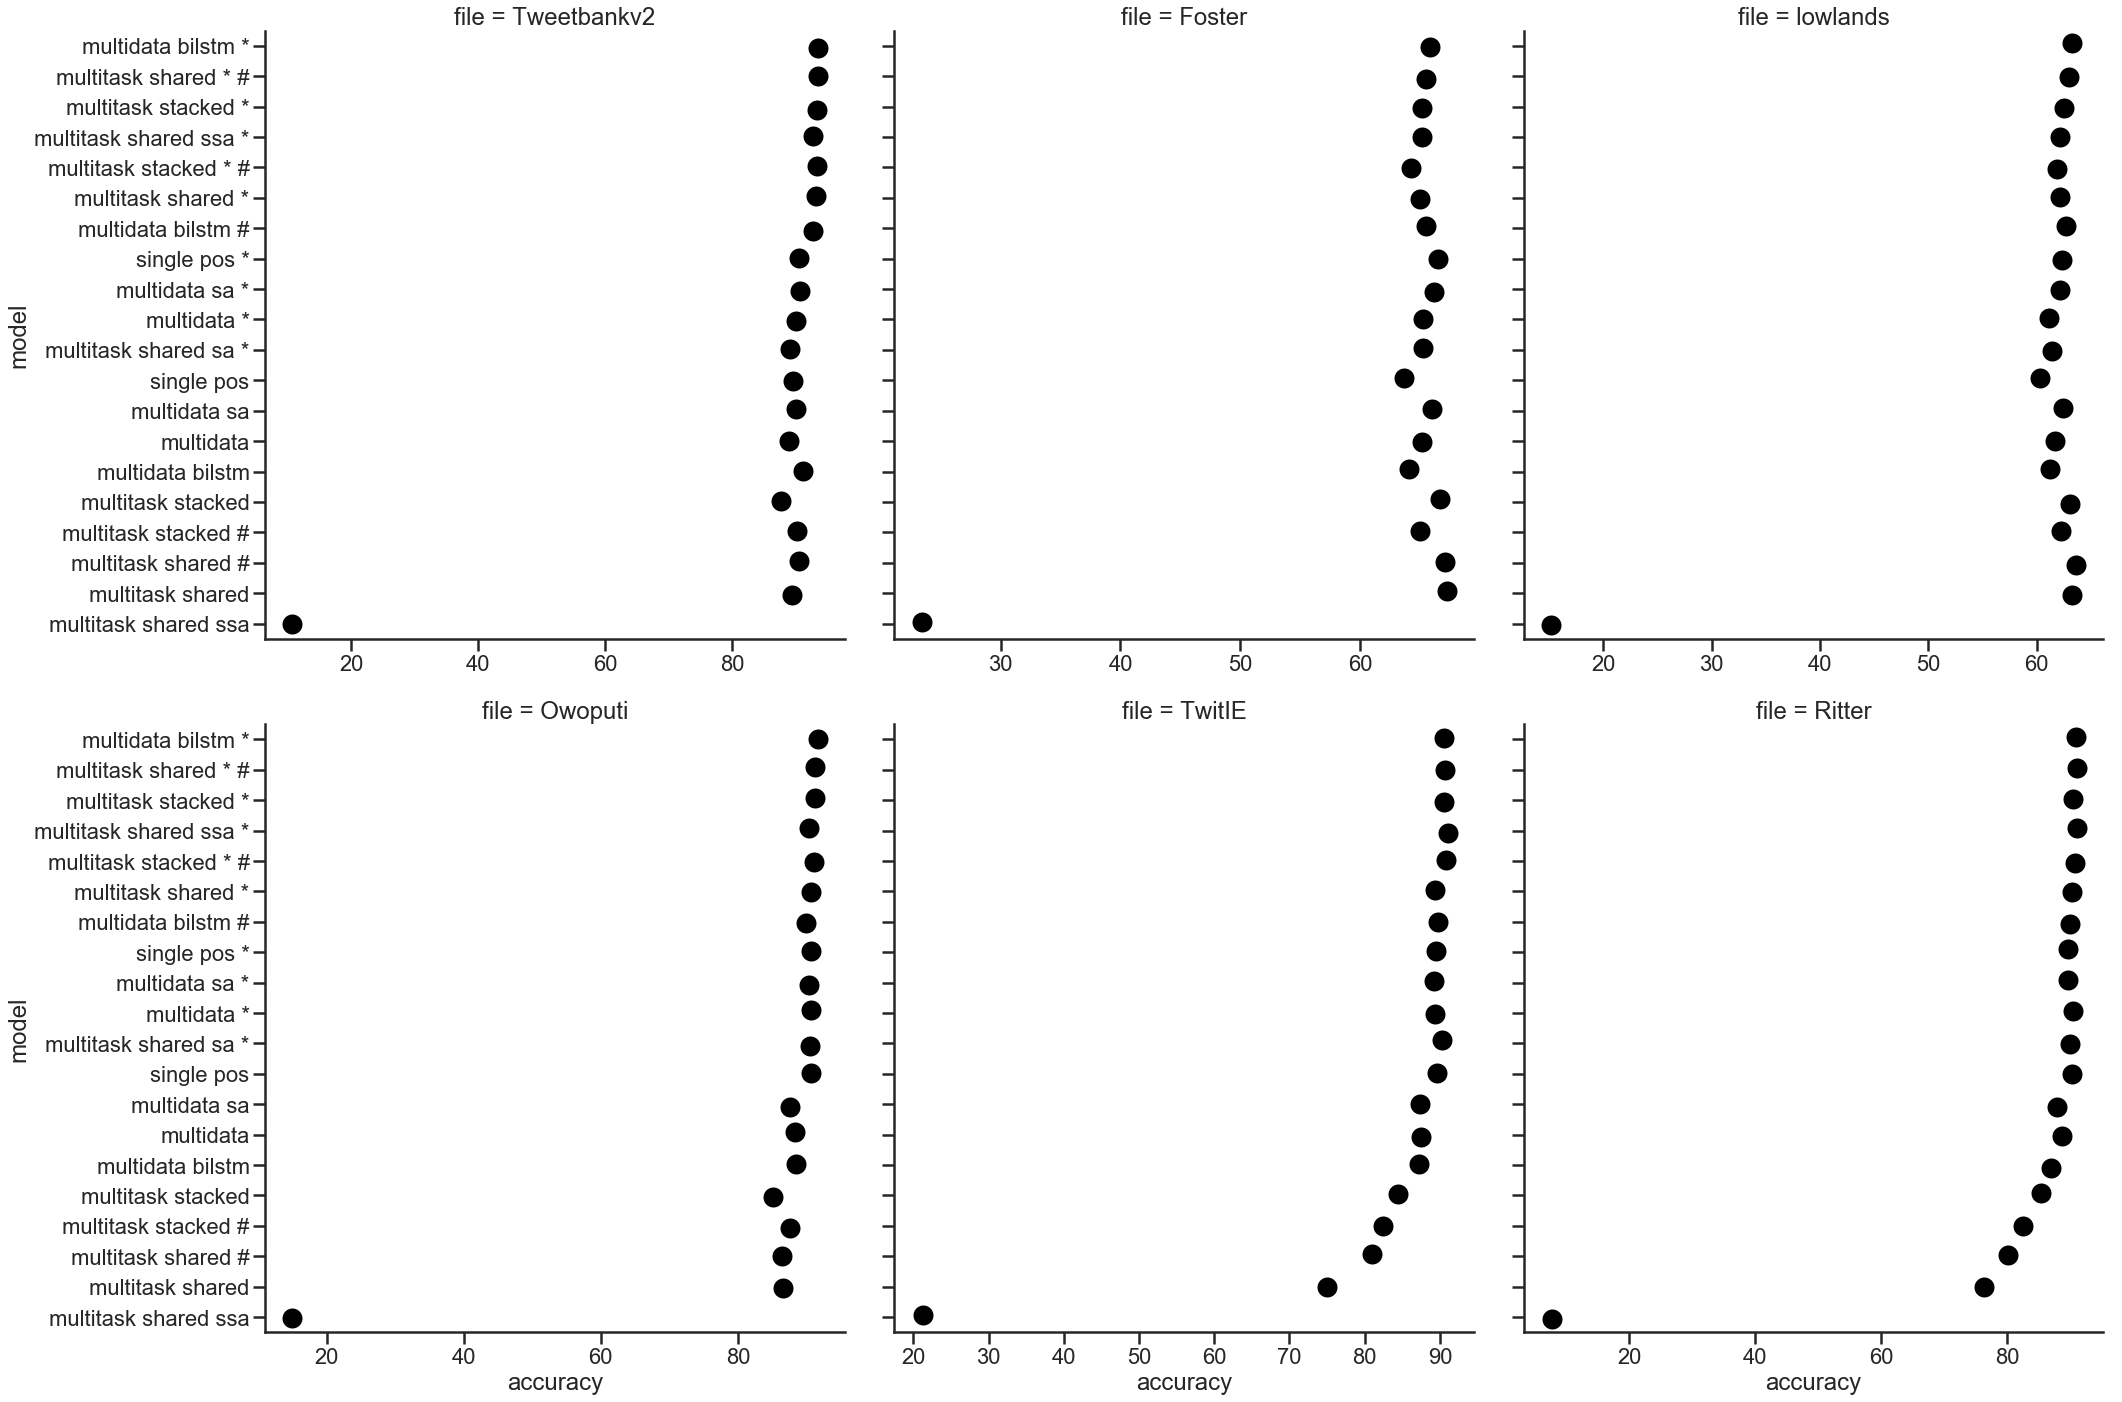

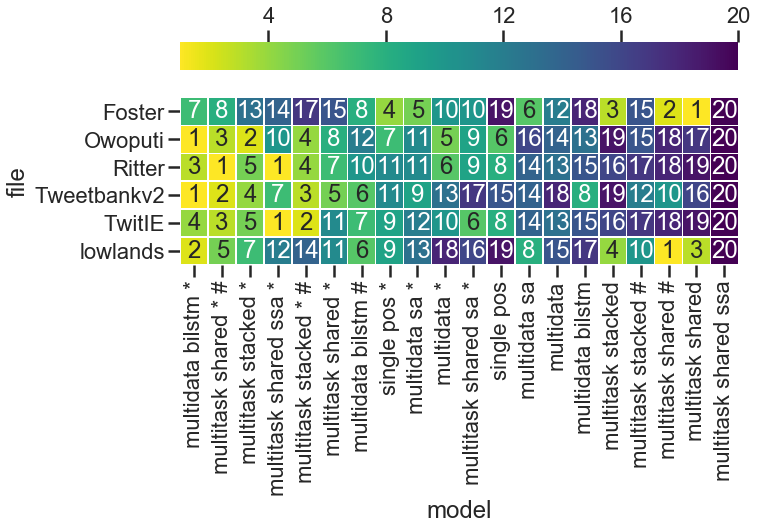

In [9]:
df_t = plot_measures(df.query("file!='POS_DiMSUM2016' & model!='all multitask shared ssa'"), task="pos", measure="accuracy")

file,BROAD,Finin,Hege,MSM2013,MultiModal,NEEL2016,Ritter,WNUT2016,WNUT2017,YODIE
model,,,,,,,,,,
multidata bilstm *,75.850929,55.178089,88.937449,81.121751,73.983740,5.846154,84.090909,52.551100,45.306765,66.800805
multitask shared * #,76.410796,55.644106,89.641873,79.876161,73.477915,0.000000,87.301587,52.049911,47.586981,62.966507
multitask shared *,76.120769,54.941413,88.441664,78.872305,73.080301,6.524390,85.606061,50.704662,46.161826,62.857143
multitask stacked *,74.512503,56.683865,84.850166,80.268007,72.642723,5.289400,81.784387,48.735846,44.228571,61.389961
multitask stacked * #,76.432829,57.011114,88.562092,81.042654,72.711111,0.000000,79.104478,47.424566,45.050829,62.896825
multitask shared ssa *,72.913156,54.315141,80.684736,78.658537,71.932271,6.206615,74.538745,49.651076,48.152059,64.461248
multidata sa *,72.856477,51.831683,87.770593,79.720768,70.926717,7.059818,74.688797,47.998671,43.534763,63.005181
multidata *,71.047277,51.111666,87.224421,78.391275,70.998252,7.825371,74.678112,47.361253,43.544304,63.050154
multitask shared sa *,71.186035,51.265588,87.170868,78.134715,70.884784,6.414320,74.576271,47.991968,41.699346,60.169492


file                   BROAD        Finin        Hege        MSM2013         \
                           r      v     r      v    r      v       r      v   
model                                                                         
multidata bilstm *         4  75.85     4  55.18    2  88.94       1  81.12   
multitask shared * #       2  76.41     3  55.64    1  89.64       4  79.88   
multitask shared *         3  76.12     5  54.94    4  88.44       6  78.87   
multitask stacked *        5  74.51     2  56.68   17  84.85       3  80.27   
multitask stacked * #      1  76.43     1  57.01    3  88.56       2  81.04   
multitask shared ssa *     7  72.91     6  54.32   18  80.68       7  78.66   
multidata sa *             8  72.86    11  51.83    6  87.77       5  79.72   
multidata *               12  71.05    15  51.11    9  87.22      10  78.39   
multitask shared sa *     11  71.19    12  51.27   10  87.17      12  78.13   
single ner *              10  71.39    13  51.26   11  87.12       8  78.51   
single ner                15  68.65    17  50.57   13  86.50       9  78.41   
multidata bilstm           9  72.26     7  53.28    5  88.44      11  78.32   
multidata bilstm #         6  73.77     9  52.44    7  87.44      14  76.61   
multidata                 14  68.67    18  49.91   14  85.94      13  77.16   
multitask stacked #       13  69.69     8  52.51    8  87.41      15  76.36   
multidata sa              19  65.48    19  49.58   15  85.45      17  75.60   
multitask shared #        17  66.58    10  51.84   12  86.87      18  74.30   
multitask stacked         18  65.57    16  51.01   16  84.86      19  73.18   
multitask shared          16  68.38    14  51.18   19  72.63      16  75.76   
multitask shared ssa      20   0.00    20   0.00   20   0.00      20   0.00   

file                   MultiModal        NEEL2016       Ritter         \
                                r      v        r     v      r      v   
model                                                                   
multidata bilstm *              1  73.98       11  5.85      3  84.09   
multitask shared * #            2  73.48       17  0.00      1  87.30   
multitask shared *              3  73.08        7  6.52      2  85.61   
multitask stacked *             5  72.64       13  5.29      4  81.78   
multitask stacked * #           4  72.71       17  0.00      5  79.10   
multitask shared ssa *          6  71.93        9  6.21      9  74.54   
multidata sa *                  8  70.93        6  7.06      6  74.69   
multidata *                     7  71.00        2  7.83      7  74.68   
multitask shared sa *           9  70.88        8  6.41      8  74.58   
single ner *                   10  70.83        1  8.26     11  70.83   
single ner                     11  68.79        4  7.53     10  71.43   
multidata bilstm               16  67.60        3  7.61     12  55.86   
multidata bilstm #             12  68.71       17  0.00     13  53.74   
multidata                      14  68.24        5  7.10     14  53.70   
multitask stacked #            17  64.96       17  0.00     17  50.69   
multidata sa                   13  68.50       10  5.85     15  51.53   
multitask shared #             18  64.82       17  0.00     18  46.60   
multitask stacked              19  63.70       14  3.84     19  40.00   
multitask shared               15  68.04       12  5.42     16  50.72   
multitask shared ssa           20   0.00       17  0.00     20   0.00   

file                   WNUT2016        WNUT2017        YODIE         
                              r      v        r      v     r      v  
model                                                                
multidata bilstm *            1  52.55        4  45.31     1  66.80  
multitask shared * #          2  52.05        2  47.59     5  62.97  
multitask shared *            3  50.70        3  46.16     7  62.86  
multitask stacked *           5  48.74        6  44.23     8  61.39  
multitask st

\begin{tabular}{lrrrrrrrrrrrrrrrrrrrr}
\toprule
\textbf{file} & \multicolumn{2}{c}{BROAD} & \multicolumn{2}{c}{Finin} & \multicolumn{2}{c}{Hege} & \multicolumn{2}{c}{MSM2013} & \multicolumn{2}{c}{MultiModal} & \multicolumn{2}{c}{NEEL2016} & \multicolumn{2}{c}{Ritter} & \multicolumn{2}{c}{WNUT2016} & \multicolumn{2}{c}{WNUT2017} & \multicolumn{2}{c}{YODIE} \\
{} &     r &      v &     r &      v &    r &      v &       r &      v &          r &      v &        r &     v &      r &      v &        r &      v &        r &      v &     r &      v \\
\textbf{model                 } &       &        &       &        &      &        &         &        &            &        &          &       &        &        &          &        &          &        &       &        \\
\midrule
\textbf{multidata bilstm *    } &     4 &  75.85 &     4 &  55.18 &    2 &  88.94 &       1 &  81.12 &          1 &  73.98 &       11 &  5.85 &      3 &  84.09 &        1 &  52.55 &        4 &  45.31 &     1 &  66.80 \\

,model,score
file,,
BROAD,multitask stacked * #,76.432829
Finin,multitask stacked * #,57.011114
Hege,multitask shared * #,89.641873
MSM2013,multidata bilstm *,81.121751
MultiModal,multidata bilstm *,73.983740
NEEL2016,single ner *,8.257987
Ritter,multitask shared * #,87.301587
WNUT2016,multidata bilstm *,52.551100
WNUT2017,multitask shared ssa *,48.152059


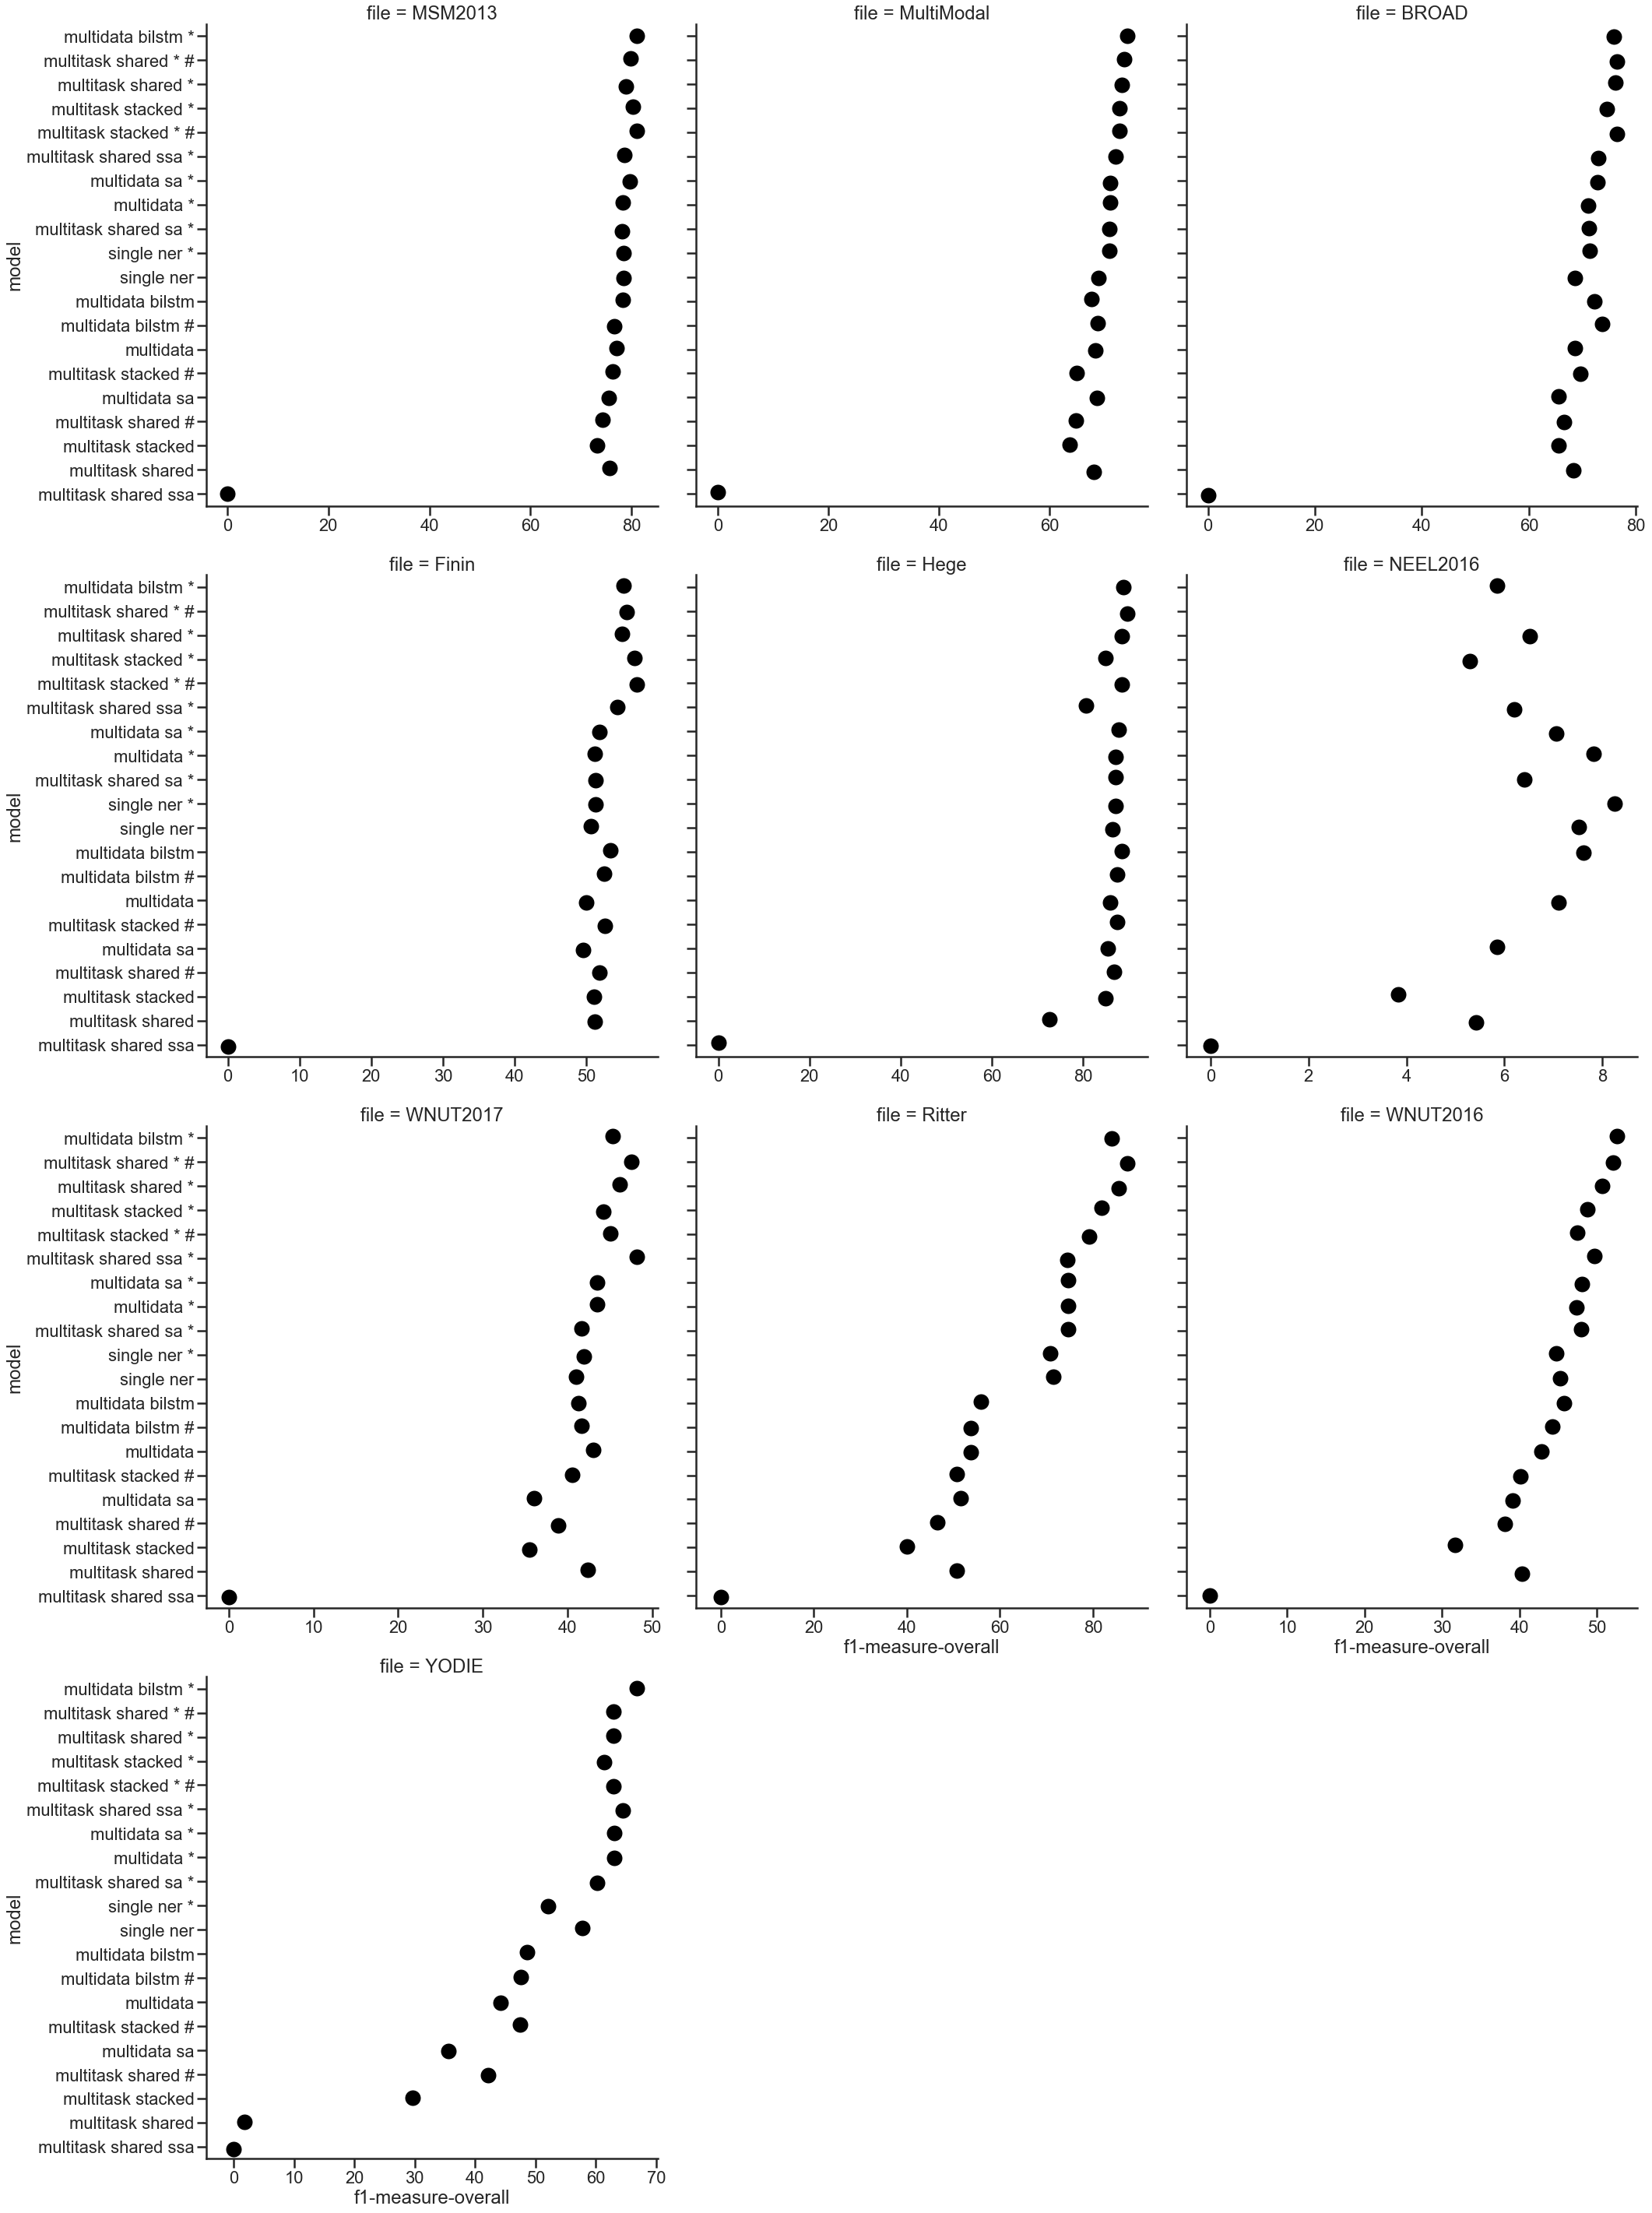

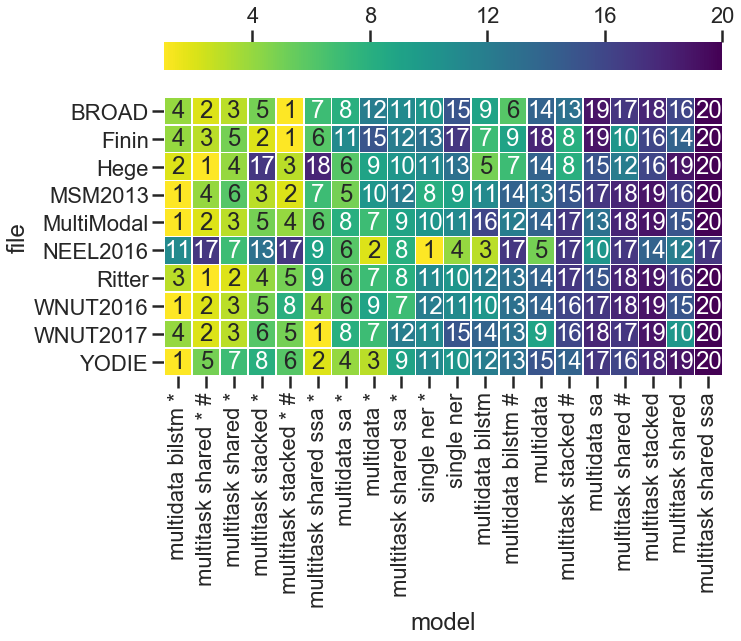

In [10]:
df_t = plot_measures(df, task="ner", measure="f1-measure-overall")

file,Ritter
model,
multitask stacked * #,87.256848
multitask shared *,86.565978
multitask shared * #,86.488641
multitask stacked *,86.448044
multitask shared sa *,83.942766
single chunk,83.618972
multitask shared ssa *,83.412322
single chunk *,79.046521
multitask stacked #,73.987976


file                   Ritter       
                            r      v
model                               
multitask stacked * #       1  87.26
multitask shared *          2  86.57
multitask shared * #        3  86.49
multitask stacked *         4  86.45
multitask shared sa *       5  83.94
single chunk                6  83.62
multitask shared ssa *      7  83.41
single chunk *              8  79.05
multitask stacked #         9  73.99
multitask shared           10  73.62
multitask shared #         11  73.13
multitask stacked          12  69.25
multitask shared ssa       13   0.00

\begin{tabular}{lrr}
\toprule
\textbf{file} & \multicolumn{2}{c}{Ritter} \\
{} &      r &      v \\
\textbf{model                 } &        &        \\
\midrule
\textbf{multitask stacked * \# } &      1 &  87.26 \\
\textbf{multitask shared *    } &      2 &  86.57 \\
\textbf{multitask shared * \#  } &      3 &  86.49 \\
\textbf{multitask stacked *   } &      4 &  86.45 \\
\textbf{multitask shared sa * } &      5 &  83.94 \\
\textbf{single chunk          } &      6 &  83.62 \\
\textbf{multitask shared ssa *} &      7 &  83.41 \\
\textbf{single chunk *        } &      8 &  79.05 \\
\textbf{multitask stacked \#   } &      9 &  73.99 \\
\textbf{multitask shared      } &     10 &  73.62 \\
\textbf{multitask shared \#    } &     11 &  73.13 \\
\textbf{multitask stacked     } &     12 &  69.25 \\
\textbf{multitask shared ssa  } &     13 &   0.00 \\
\bottomrule
\end{tabular}

Index(['Ritter'], dtype='object', name='file')


,model,score
file,,
Ritter,multitask stacked * #,87.256848


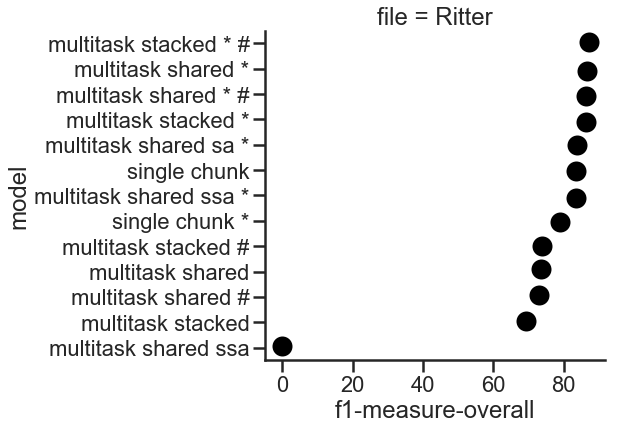

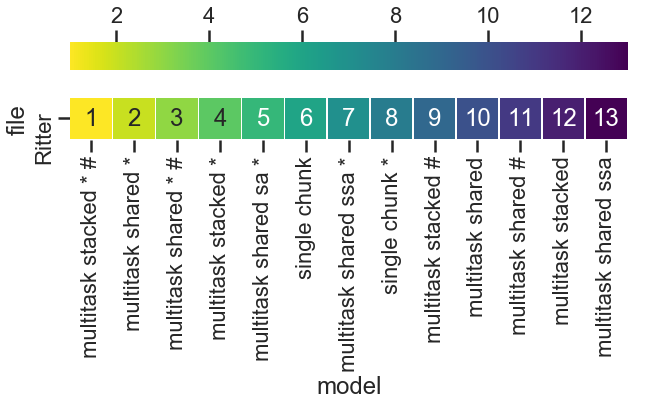

In [11]:
df_t = plot_measures(df, task="chunk", measure="f1-measure-overall")

file,Johannsen2014,Ritter
model,,
single ccg,37.505568,59.743763
multitask shared sa *,37.545126,59.699454
single ccg *,37.935376,57.762712
multitask shared *,36.396891,56.874581
multitask shared ssa *,35.283993,55.287818
multitask shared * #,32.291667,54.606590
multitask stacked *,28.019758,47.471342
multitask stacked * #,25.322284,45.288136
multitask shared,22.133995,36.578581


file                   Johannsen2014        Ritter       
                                   r      v      r      v
model                                                    
single ccg                         3  37.51      1  59.74
multitask shared sa *              2  37.55      2  59.70
single ccg *                       1  37.94      3  57.76
multitask shared *                 4  36.40      4  56.87
multitask shared ssa *             5  35.28      5  55.29
multitask shared * #               6  32.29      6  54.61
multitask stacked *                7  28.02      7  47.47
multitask stacked * #              8  25.32      8  45.29
multitask shared                  10  22.13      9  36.58
multitask shared #                 9  23.04     10  34.36
multitask stacked                 12   8.01     11  17.72
multitask stacked #               11  12.49     12   9.84
multitask shared ssa              13   0.00     13   0.00

\begin{tabular}{lrrrr}
\toprule
\textbf{file} & \multicolumn{2}{c}{Johannsen2014} & \multicolumn{2}{c}{Ritter} \\
{} &             r &      v &      r &      v \\
\textbf{model                 } &               &        &        &        \\
\midrule
\textbf{single ccg            } &             3 &  37.51 &      1 &  59.74 \\
\textbf{multitask shared sa * } &             2 &  37.55 &      2 &  59.70 \\
\textbf{single ccg *          } &             1 &  37.94 &      3 &  57.76 \\
\textbf{multitask shared *    } &             4 &  36.40 &      4 &  56.87 \\
\textbf{multitask shared ssa *} &             5 &  35.28 &      5 &  55.29 \\
\textbf{multitask shared * \#  } &             6 &  32.29 &      6 &  54.61 \\
\textbf{multitask stacked *   } &             7 &  28.02 &      7 &  47.47 \\
\textbf{multitask stacked * \# } &             8 &  25.32 &      8 &  45.29 \\
\textbf{multitask shared      } &            10 &  22.13 &      9 &  36.58 \\
\textbf{multitask shared \#    } &            

,model,score
file,,
Johannsen2014,single ccg *,37.935376
Ritter,single ccg,59.743763


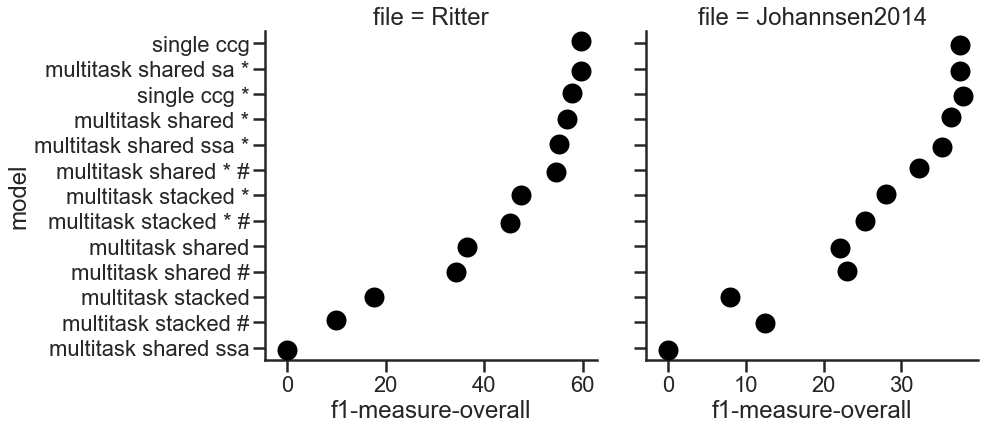

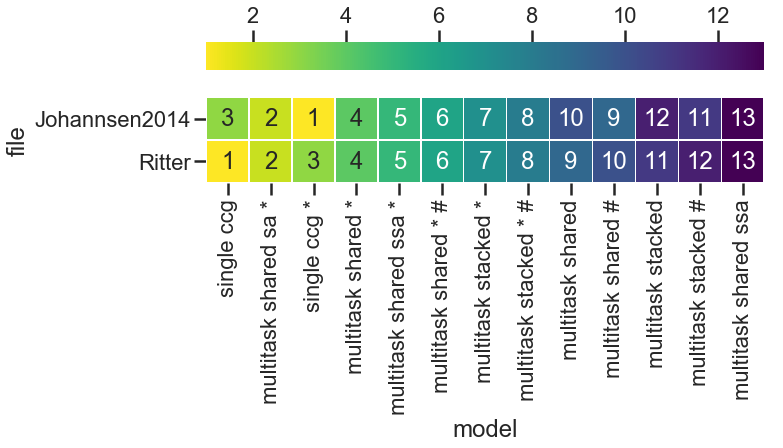

In [12]:
df_t = plot_measures(df, task="ccg", measure="f1-measure-overall")

In [13]:
pd.concat([df_t, df_t.apply(lambda x: x.argsort())], axis=1)

file,Johannsen2014,Ritter,Johannsen2014,Ritter
model,,,,
single ccg,37.505568,59.743763,12,12
multitask shared sa *,37.545126,59.699454,10,11
single ccg *,37.935376,57.762712,11,10
multitask shared *,36.396891,56.874581,8,9
multitask shared ssa *,35.283993,55.287818,9,8
multitask shared * #,32.291667,54.606590,7,7
multitask stacked *,28.019758,47.471342,6,6
multitask stacked * #,25.322284,45.288136,5,5
multitask shared,22.133995,36.578581,4,4
